In [192]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import scanpy as sc
sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=180, dpi_save=300, 
                              frameon=False, figsize=(4, 4), 
                              fontsize=8, facecolor='white')

In [193]:
sequencing_data_folder = r'/lab/solexa_weissman/puzheng/Sequencing_data/GSE223896'
library_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign'
if not os.path.exists(library_folder):
    os.makedirs(library_folder)
    
# label
label_key = 'annotation'

In [4]:
# Load raw WT
# Input files
wt_sample_name = 'WT_CNS_1_GEX'
for _fl in os.listdir(sequencing_data_folder):
    if wt_sample_name in _fl: # select sample
        if 'matrix.mtx' in _fl: 
            wt_mtx_file = os.path.join(sequencing_data_folder, _fl) 
        elif 'barcodes.tsv' in _fl:
            wt_barcode_file = os.path.join(sequencing_data_folder, _fl) 
        elif 'features.tsv' in _fl:
            wt_features_file = os.path.join(sequencing_data_folder, _fl) 
wt_adata_raw = sc.read_mtx(wt_mtx_file)
wt_adata_raw = wt_adata_raw.transpose() # The matrix has to be transposed because the genes and cells are fipped
# Load gene names
features = pd.read_csv(wt_features_file, sep='\t', header=None)
wt_adata_raw.var['gene_ids'] = list(features[0])
wt_adata_raw.var['gene_symbols'] = list(features[1])
wt_adata_raw.var = wt_adata_raw.var.set_index('gene_symbols')
wt_adata_raw.var_names_make_unique()
# Load cell IDs (barcodes)
barcodes = pd.read_csv(wt_barcode_file, sep=',', header=None, names=['barcode'])
new_barcodes = pd.DataFrame([f"WT_CNS_{_n.split('-')[1]}_{_n.split('-')[0]}" for _n in barcodes['barcode']],
                            columns=['barcode'])
wt_adata_raw.obs = new_barcodes.set_index('barcode')
wt_adata_raw.obs['treatment'] = 'WT'

In [5]:
# Load raw KO
# Input files
ko_sample_name = 'KO_CNS_1_GEX'
for _fl in os.listdir(sequencing_data_folder):
    if ko_sample_name in _fl: # select sample
        if 'matrix.mtx' in _fl: 
            ko_mtx_file = os.path.join(sequencing_data_folder, _fl) 
        elif 'barcodes.tsv' in _fl:
            ko_barcode_file = os.path.join(sequencing_data_folder, _fl) 
        elif 'features.tsv' in _fl:
            ko_features_file = os.path.join(sequencing_data_folder, _fl) 
ko_adata_raw = sc.read_mtx(ko_mtx_file)
ko_adata_raw = ko_adata_raw.transpose() # The matrix has to be transposed because the genes and cells are fipped
# Load gene names
features = pd.read_csv(ko_features_file, sep='\t', header=None)
ko_adata_raw.var['gene_ids'] = list(features[0])
ko_adata_raw.var['gene_symbols'] = list(features[1])
ko_adata_raw.var = ko_adata_raw.var.set_index('gene_symbols')
ko_adata_raw.var_names_make_unique()
# Load cell IDs (barcodes)
barcodes = pd.read_csv(ko_barcode_file, sep=',', header=None, names=['barcode'])
new_barcodes = pd.DataFrame([f"KO_CNS_{_n.split('-')[1]}_{_n.split('-')[0]}" for _n in barcodes['barcode']],
                            columns=['barcode'])
ko_adata_raw.obs = new_barcodes.set_index('barcode')
ko_adata_raw.obs['treatment'] = 'KO'

In [6]:
import anndata
# merge
merged_raw_adata = anndata.concat([wt_adata_raw,ko_adata_raw])
# QC
sc.pp.calculate_qc_metrics(merged_raw_adata, percent_top=None, log1p=False, inplace=True)

In [7]:
merged_raw_adata

AnnData object with n_obs × n_vars = 4970 × 32285
    obs: 'treatment', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## Load processed h5ad data

In [9]:
# load adata
nt_adata = sc.read_h5ad(os.path.join(sequencing_data_folder, 'eae_cns_nT.h5ad'))

/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


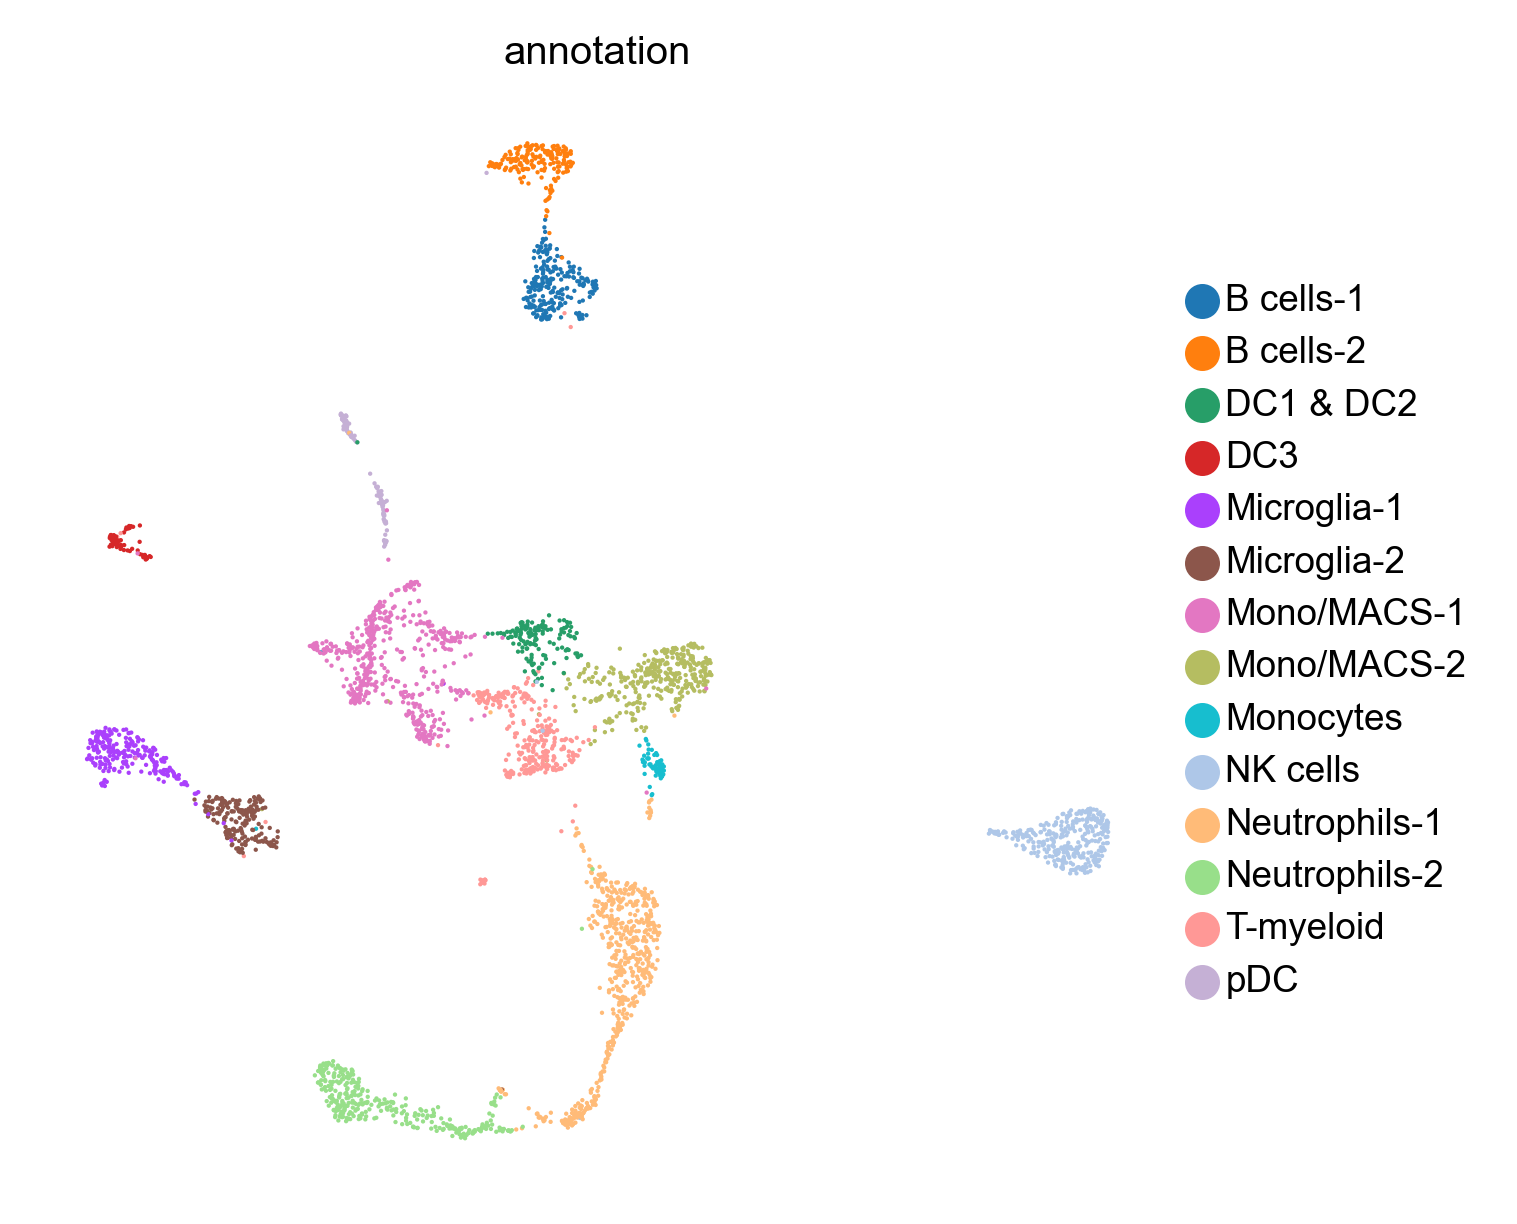

In [11]:
nt_umap = sc.pl.umap(nt_adata, color=label_key, s=3)

In [12]:
# match barcodes
update_obs_dict = {label_key:[], 'seurat_clusters_new':[]}
for _idx, _row in merged_raw_adata.obs.iterrows():
    #print(_idx)
    if _idx in nt_adata.obs.index:
        update_obs_dict[label_key].append(nt_adata.obs.loc[_idx, label_key])
        update_obs_dict['seurat_clusters_new'].append(nt_adata.obs.loc[_idx, 'seurat_clusters_new'])
    else:
        update_obs_dict[label_key].append('')
        update_obs_dict['seurat_clusters_new'].append(-1)
# update;
for _k, _v in update_obs_dict.items():
    merged_raw_adata.obs[_k] = _v

## save

In [13]:
# save
merged_raw_save_filename = os.path.join(os.path.join(library_folder, 'merged_raw.h5ad'))

overwrite = True

if not os.path.exists(merged_raw_save_filename) or overwrite:
    print(f"save adata into file: {merged_raw_save_filename}")
    merged_raw_adata.write(merged_raw_save_filename)
else:
    print(f"savefile: {merged_raw_save_filename} already exists")

save adata into file: /lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign/merged_raw.h5ad


In [25]:
# filter

filtered_raw_adata = merged_raw_adata[merged_raw_adata.obs[label_key] != '', 
                                      merged_raw_adata.var['n_cells_by_counts'] > 0]

In [26]:
filtered_raw_adata.obs

,treatment,n_genes_by_counts,total_counts,annotation,seurat_clusters_new
barcode,,,,,
WT_CNS_1_AAACCTGCAAGCCATT,WT,347,664.0,Mono/MACS-1,0
WT_CNS_1_AAACCTGCACACTGCG,WT,715,995.0,Microglia-1,7
WT_CNS_1_AAACCTGCATCTACGA,WT,973,2636.0,Neutrophils-1,2
WT_CNS_1_AAACCTGCATGCTAGT,WT,617,1547.0,Neutrophils-1,2
WT_CNS_1_AAACCTGGTGCAGGTA,WT,5094,25510.0,Microglia-2,12
...,...,...,...,...,...
KO_CNS_1_TTTGGTTTCTGATACG,KO,3950,16542.0,Mono/MACS-2,3
KO_CNS_1_TTTGTCAAGTGTTAGA,KO,2946,16517.0,Neutrophils-1,11
KO_CNS_1_TTTGTCAGTTGAGGTG,KO,821,1569.0,Neutrophils-1,2


In [28]:
# Calculate gene expression levels in the most highly expressed cell types
cluster_labels = np.unique(filtered_raw_adata.obs[label_key])

gene_max_mean_cluster_counts = np.zeros(filtered_raw_adata.var.shape[0])

for cl in cluster_labels:
    gene_mean_cluster_counts = np.array(np.mean(filtered_raw_adata.X[filtered_raw_adata.obs[label_key] == cl], 
                                                axis=0)).flatten()
    gene_max_mean_cluster_counts = np.maximum(gene_max_mean_cluster_counts, gene_mean_cluster_counts)

filtered_raw_adata.var['max_mean_cluster_count'] = gene_max_mean_cluster_counts

/tmp/ipykernel_3620709/1618235390.py:11: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  filtered_raw_adata.var['max_mean_cluster_count'] = gene_max_mean_cluster_counts


### save

In [31]:
filtered_raw_save_filename = os.path.join(os.path.join(library_folder, 'filtered_raw.h5ad'))

overwrite = True

if not os.path.exists(filtered_raw_save_filename) or overwrite:
    print(f"save adata into file: {filtered_raw_save_filename}")
    filtered_raw_adata.write(filtered_raw_save_filename)
else:
    print(f"savefile: {filtered_raw_save_filename} already exists")

save adata into file: /lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign/filtered_raw.h5ad


### load and start from here:

In [32]:
## de-novo umap for filtered_data
filtered_raw_adata = sc.read_h5ad(filtered_raw_save_filename)

# Load manual selected genes

In [33]:
print(library_folder)

/lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign


In [36]:
ls /lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign

filtered_raw.h5ad  Merfish_library_EAE.xlsx*  merged_raw.h5ad


In [37]:
selected_gene_filename = os.path.join(library_folder,
                                     'Merfish_library_EAE.xlsx')
selected_gene_df = pd.read_excel(selected_gene_filename, index_col=None)
# cleanup
type_2_genes = {_t:[_g for _g in selected_gene_df[_t].values if isinstance(_g, str)]
                for _t in selected_gene_df.columns}
#type_2_genes = 

In [170]:
selected_gene_list = []
for _type, _genes in type_2_genes.items():
    selected_gene_list += _genes
selected_gene_list = np.unique(selected_gene_list)

In [39]:
for _gene in selected_gene_list:
    if _gene not in merged_raw_adata.var.index:
        print(_gene)

## Umap for original data

In [40]:
# Preprocess
filtered_adata = filtered_raw_adata.copy()
# Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell
sc.pp.normalize_total(filtered_adata, target_sum=1e3)
# Logarithmize the data
sc.pp.log1p(filtered_adata)
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(filtered_adata, max_value=10)

/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


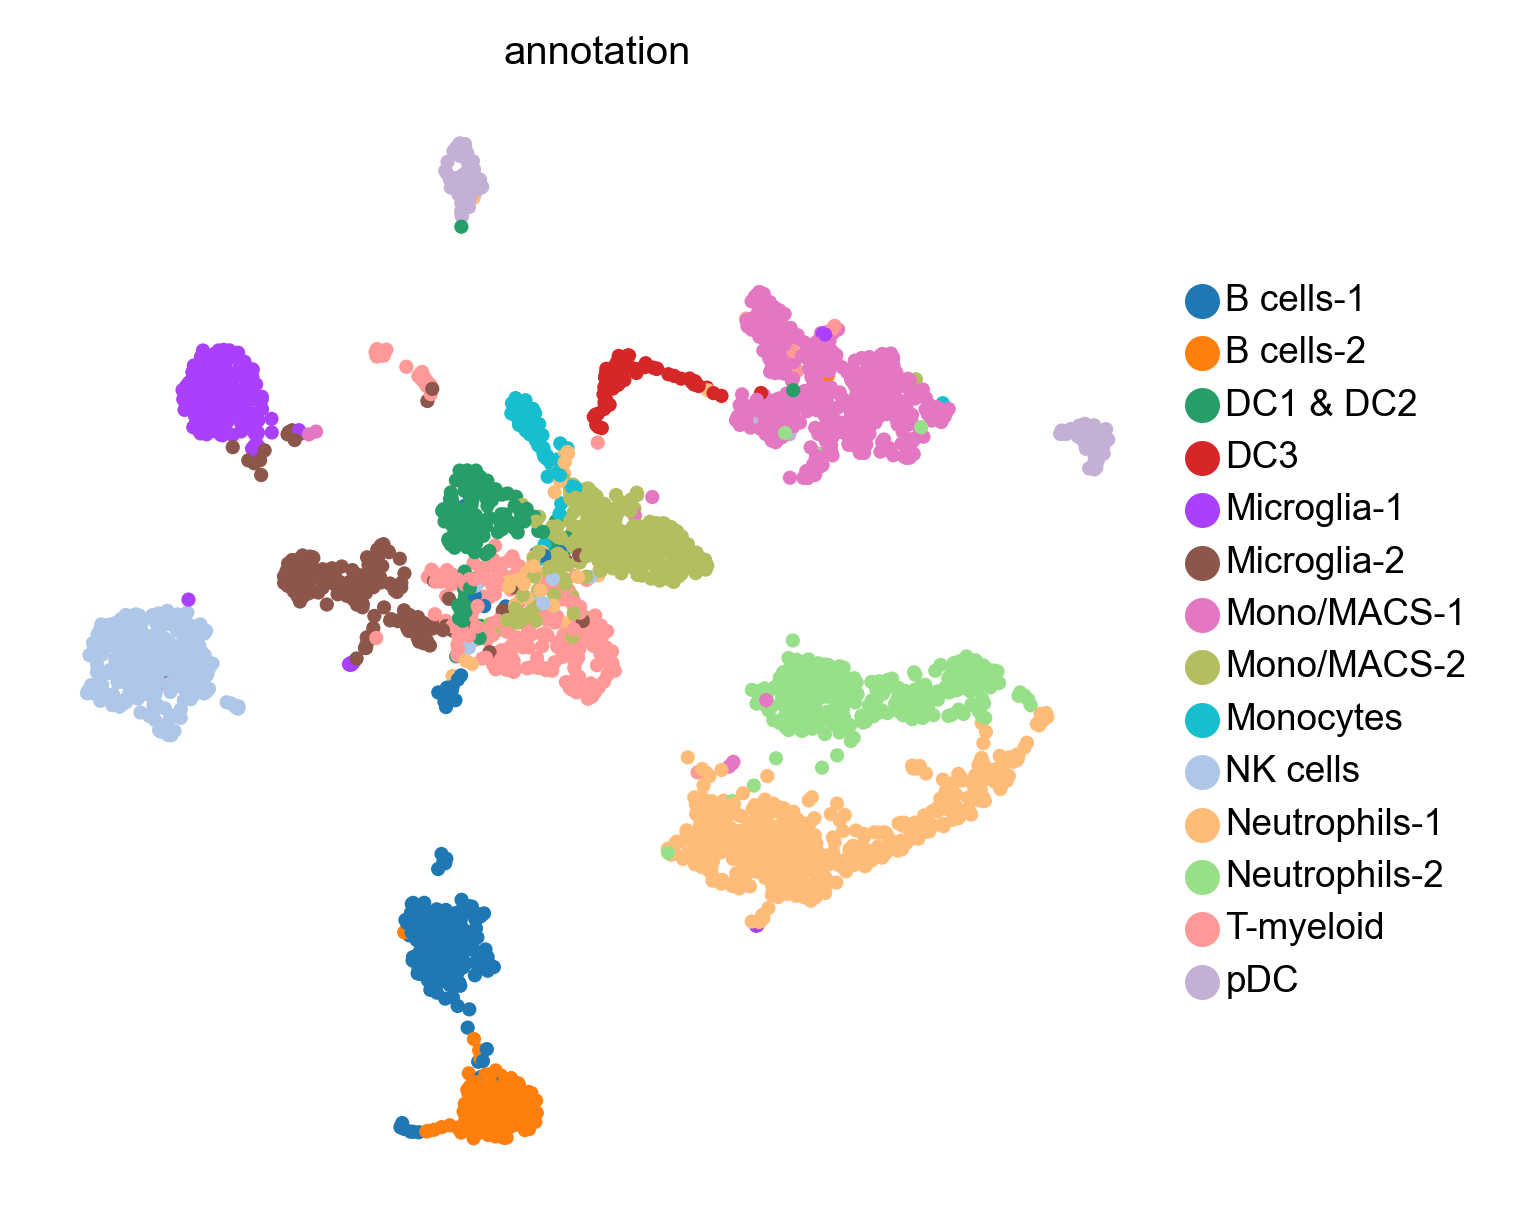

CPU times: user 1min 34s, sys: 2.21 s, total: 1min 36s
Wall time: 8.67 s


In [42]:
%%time
# Plot the clusters onto UMAP
# Principal component analysis
sc.tl.pca(filtered_adata, svd_solver='arpack')
# Computing the neighborhood graph
sc.pp.neighbors(filtered_adata, n_neighbors=8, n_pcs=30)
# Embed with UMAP
sc.tl.umap(filtered_adata)
# Plot the clusters (it seems that there are some batch effect in this dataset)
sc.pl.umap(filtered_adata, color='annotation')

## Filter candidate marker genes

In [47]:
filtered_adata.raw = filtered_raw_adata

In [48]:
# Calculate gene expression in all cell annotated types and keep the max
cluster_labels = np.unique(filtered_adata.obs[label_key])

gene_max_mean_cluster_counts = np.zeros(filtered_adata.var.shape[0])

for cl in cluster_labels:
    gene_mean_cluster_counts = np.array(np.mean(filtered_adata.raw.X[filtered_adata.obs[label_key] == cl], axis=0)).flatten()
    gene_max_mean_cluster_counts = np.maximum(gene_max_mean_cluster_counts, gene_mean_cluster_counts)

filtered_adata.var['max_mean_cluster_count'] = gene_max_mean_cluster_counts

In [49]:
# Filter the genes by gene type and expression level
filtered_genes = np.array(filtered_adata.var.index)

# Remove the highly expressed genes that may cause over-crowding in MERFISH
percentile_threshold = 90 # remove top 1 percent genes
mask1 = filtered_adata.var['mean_counts'] < np.percentile(filtered_adata.var['mean_counts'], percentile_threshold)
mask2 = filtered_adata.var['max_mean_cluster_count'] < np.percentile(filtered_adata.var['max_mean_cluster_count'], percentile_threshold)
mask = mask1 & mask2
filtered_genes = filtered_genes[mask]

# Remove all mitochondrial genes
mask = [not g.lower().startswith('mt-') for g in filtered_genes]
filtered_genes = filtered_genes[mask]

## Select marker genes

## select

In [72]:
# Filter the genes by gene type and expression level
filtered_genes = np.array(filtered_raw_adata.var.index)

# Remove the highly expressed genes that may cause over-crowding in MERFISH
percentile_threshold = 90 # remove top 1 percent genes
mask1 = filtered_raw_adata.var['mean_counts'] < np.percentile(filtered_raw_adata.var['mean_counts'], percentile_threshold)
mask2 = filtered_raw_adata.var['max_mean_cluster_count'] < np.percentile(filtered_raw_adata.var['max_mean_cluster_count'], percentile_threshold)
mask = mask1 & mask2
filtered_genes = filtered_genes[mask]

# Remove all mitochondrial genes
mask = [not g.lower().startswith('mt-') for g in filtered_genes]
filtered_genes = filtered_genes[mask]

In [194]:
%%time
# Select the marker genes
adata_filtered = filtered_raw_adata[:, filtered_raw_adata.var.index.isin(filtered_genes)]
# Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell
sc.pp.normalize_total(adata_filtered, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata_filtered)

# Define the marker genes as the differentially expressed genes
sc.tl.rank_genes_groups(adata_filtered, label_key, method='wilcoxon')


/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


CPU times: user 4.44 s, sys: 566 ms, total: 5.01 s
Wall time: 5 s


In [216]:
len(np.unique(marker_gene_groups))

15

In [217]:
marker_gene_groups

['manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',

In [283]:
# Select the top marker genes
N_genes_to_select = 430
min_genes_per_group = 3

logFoldChange_th = 0.5
# init marker genes
marker_genes = set(selected_gene_list)
marker_gene_groups = list(['manual']*len(selected_gene_list))

group_names = list(adata_filtered.uns['rank_genes_groups']['names'].dtype.names)

for i in range(len(adata_filtered.uns['rank_genes_groups']['names'])):
    new_markers = set(adata_filtered.uns['rank_genes_groups']['names'][i])
    log_fold_change = set(adata_filtered.uns['rank_genes_groups']['logfoldchanges'][i])
    for j, (m, _l) in enumerate(zip(new_markers, log_fold_change)):
        if m not in marker_genes and _l >= logFoldChange_th:
            marker_genes.add(m)
            marker_gene_groups.append(group_names[j])
            if len(marker_genes) >= N_genes_to_select:
                break
            
    if len(marker_genes) >= N_genes_to_select:
            break

marker_genes = np.array(list(marker_genes))
print(f'Found {len(marker_genes)} marker genes.')

Found 430 marker genes.


In [284]:
selected_genes = marker_genes

In [285]:
# Calculate gene expression levels in the most highly expressed cell types
cluster_labels = np.unique(filtered_raw_adata.obs[label_key])

gene_max_mean_cluster_counts = np.zeros(filtered_raw_adata.var.shape[0])

for cl in cluster_labels:
    gene_mean_cluster_counts = np.array(np.mean(filtered_raw_adata.X[filtered_raw_adata.obs[label_key] == cl], axis=0)).flatten()
    gene_max_mean_cluster_counts = np.maximum(gene_max_mean_cluster_counts, gene_mean_cluster_counts)

filtered_raw_adata.var['max_mean_cluster_count'] = gene_max_mean_cluster_counts

/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


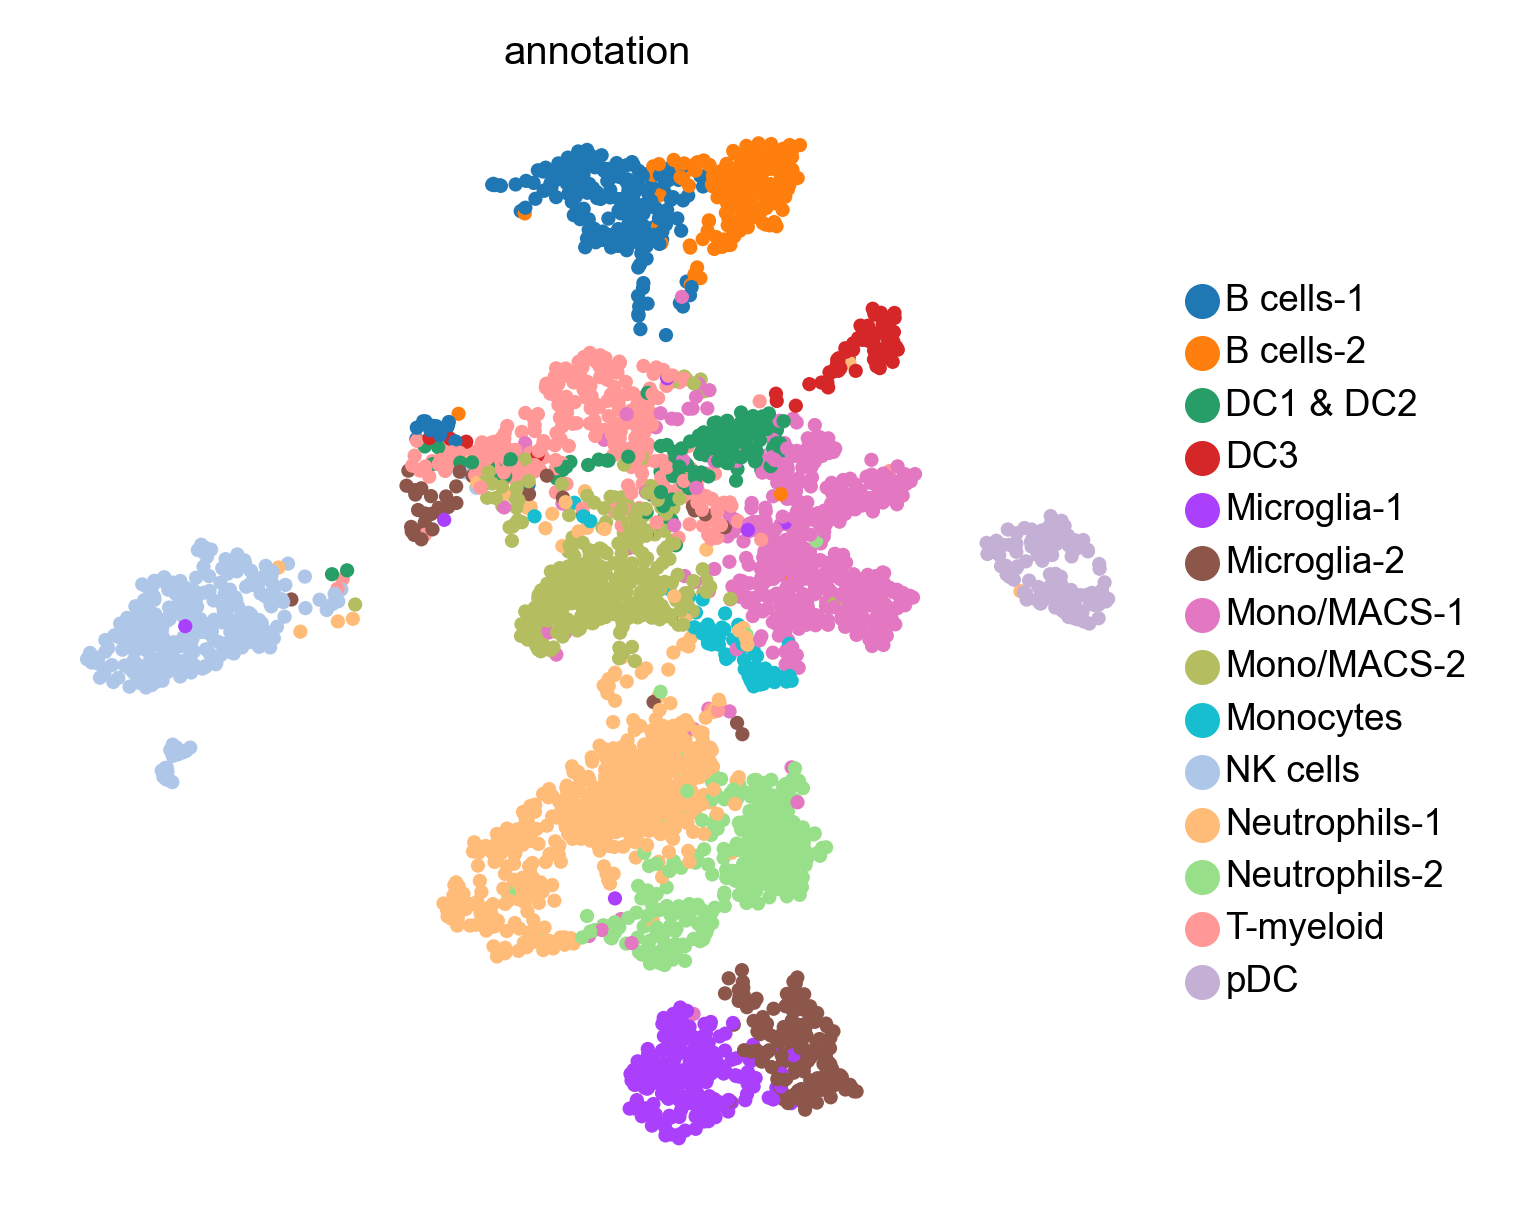

CPU times: user 24.7 s, sys: 1.48 s, total: 26.2 s
Wall time: 5.5 s


In [286]:
%%time
# Validate that the selected genes recapitulate the cluster structures
adata_selected = filtered_adata[:, filtered_adata.var.index.isin(marker_genes)]
# Principal component analysis
sc.tl.pca(adata_selected, svd_solver='arpack')
# Computing the neighborhood graph
sc.pp.neighbors(adata_selected, n_neighbors=5, n_pcs=30)
# Embed with UMAP
sc.tl.umap(adata_selected)
# Plot the clusters
sc.pl.umap(adata_selected, color=label_key)
# Interestingly, the selected genes also removed the batch effect

# Check gene expression in each type

In [287]:
# cell type specific expression
CellTypeMeanExp = pd.DataFrame()
for cell_type in merged_raw_adata.obs.annotation.value_counts().index:
    if cell_type == '':
        continue
    _type_adata = merged_raw_adata[merged_raw_adata.obs[label_key] == cell_type]
    sc.pp.calculate_qc_metrics(_type_adata, percent_top=None, log1p=False, inplace=True)
    print(cell_type)
    # save mean
    CellTypeMeanExp[cell_type] = _type_adata.var['mean_counts']
    #break

/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as

Neutrophils-1
Mono/MACS-1
Mono/MACS-2
Neutrophils-2
NK cells
T-myeloid
Microglia-1
B cells-1
B cells-2
Microglia-2
DC1 & DC2
pDC
DC3
Monocytes


/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as

In [288]:
CellTypeUmiFrac = CellTypeMeanExp.copy()
for cell_type in CellTypeUmiFrac.columns:
    CellTypeUmiFrac[cell_type] = CellTypeUmiFrac[cell_type] / np.sum(CellTypeUmiFrac[cell_type])

## calculate umi fraction of selected genes

In [289]:
CellTypeUmiFrac.columns

Index(['Neutrophils-1', 'Mono/MACS-1', 'Mono/MACS-2', 'Neutrophils-2',
       'NK cells', 'T-myeloid', 'Microglia-1', 'B cells-1', 'B cells-2',
       'Microglia-2', 'DC1 & DC2', 'pDC', 'DC3', 'Monocytes'],
      dtype='object')

In [290]:
CellTypeUmiFrac.loc[marker_genes].values.sum(0)

array([0.22390181, 0.04942987, 0.03107591, 0.0622004 , 0.0486076 ,
       0.0536241 , 0.05073124, 0.04915228, 0.05582463, 0.04962296,
       0.05347505, 0.03715534, 0.05498706, 0.03585345], dtype=float32)

In [291]:
print(marker_genes)

['Cd19' 'Map4k1' 'Gm8369' 'Fpr1' 'Sesn1' 'Anapc13' 'Bmyc' 'Dock4' 'Parp1'
 'Slc4a8' 'Il23a' 'Rasa4' 'Rilpl2' 'Psmg4' 'Pfkfb4' '2310001H17Rik' 'Lyz1'
 'Dab2' 'Ms4a1' 'Ebp' 'Ythdf3' 'Cd79a' 'Lag3' 'Cd69' 'Adamts14' 'Mirt1'
 'Tcf7' 'Hip1' 'Abcg3' 'Gna15' 'Tmem86a' 'Gm19585' 'Gal3st4' 'Carhsp1'
 'Rpgrip1' 'Ciita' 'Siglece' 'Sdhaf1' 'Ccl22' 'Cd28' 'Zfp318' 'Lamtor5'
 'Stom' 'Ntpcr' 'Cd44' 'Tarm1' 'Usp12' 'Il1f9' 'Hpgd' 'Vars' 'Myof'
 'Bcar3' 'Tnf' 'Mrpl58' 'Dhrs9' 'Fcer2a' 'Il1a' 'Ptprc' 'Trem3' 'St6gal1'
 'Ralgps2' 'Vps13c' 'Phospho1' 'Ikzf3' 'Ifi211' 'Agtrap' 'Trappc2l'
 'Cxcr5' 'Lifr' 'Tcrg-C4' 'Mgam' 'Abca1' 'Trem2' 'Arsb' 'Comt' 'Arg2'
 'Klhl2' 'Pbx1' 'Dynll2' 'Dach1' 'Rtcb' 'Eepd1' 'Hipk2' 'Flt3' 'Abtb1'
 'Cx3cr1' 'P2ry10' 'Hvcn1' 'Pakap-1' 'Gata3' 'Slc7a8' 'Tcrg-C1' 'Nfe2'
 'Cd8a' 'Bcl6' 'Csf2' 'Tet2' 'Itprid2' 'Eomes' 'Nkg7' 'Tnfsf13' 'Lyve1'
 'Fnbp1l' 'Ctla4' 'Clec4d' 'Nrp2' 'Itgam' 'Arhgef40' 'Tmem38b' 'Csf3r'
 'Ophn1' 'C1galt1c1' 'Cmtm3' 'Cyth3' 'Nav3' 'F13a1' 'Spire1' 'Batf3'
 '

In [292]:
marker_gene_groups

['manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',

In [293]:
# remove gene with very high umi
gene_to_remove = []
soft_celltype_th = 3
hard_xs, hard_ys = np.where(CellTypeUmiFrac > 0.008)
soft_xs, soft_ys = np.where(CellTypeUmiFrac > 0.004)

for _ix, _iy in zip(hard_xs, hard_ys):
    _gene = CellTypeUmiFrac.index[_ix]
    _type = CellTypeUmiFrac.columns[_iy]
    if _gene not in gene_to_remove:
        print(f"hard remove: {_gene}")
        gene_to_remove.append(_gene)
print(f"hard remove: {gene_to_remove}")
# soft
for _ix, _iy in zip(soft_xs, soft_ys):
    _gene = CellTypeUmiFrac.index[_ix]
    _type = CellTypeUmiFrac.columns[_iy]
    
    if _gene not in gene_to_remove and np.sum(soft_xs==_ix) >= soft_celltype_th:
        print(f"soft remove: {_gene}")
        gene_to_remove.append(_gene)
print(f"soft remove: {gene_to_remove}")

hard remove: Lcn2
hard remove: Cst3
hard remove: S100a8
hard remove: S100a9
hard remove: Actb
hard remove: Tmsb10
hard remove: Camp
hard remove: Ngp
hard remove: Ltf
hard remove: Lyz2
hard remove: Ccl5
hard remove: Actg1
hard remove: Gzma
hard remove: Retnlg
hard remove: H2-Aa
hard remove: Gm42418
hard remove: Cd74
hard remove: Malat1
hard remove: Fth1
hard remove: Tmsb4x
hard remove: mt-Co1
hard remove: ['Lcn2', 'Cst3', 'S100a8', 'S100a9', 'Actb', 'Tmsb10', 'Camp', 'Ngp', 'Ltf', 'Lyz2', 'Ccl5', 'Actg1', 'Gzma', 'Retnlg', 'H2-Aa', 'Gm42418', 'Cd74', 'Malat1', 'Fth1', 'Tmsb4x', 'mt-Co1']
soft remove: B2m
soft remove: Rps9
soft remove: Ifitm3
soft remove: Rpl13
soft remove: Eef1a1
soft remove: Psap
soft remove: Rps24
soft remove: Tpt1
soft remove: Fau
soft remove: ['Lcn2', 'Cst3', 'S100a8', 'S100a9', 'Actb', 'Tmsb10', 'Camp', 'Ngp', 'Ltf', 'Lyz2', 'Ccl5', 'Actg1', 'Gzma', 'Retnlg', 'H2-Aa', 'Gm42418', 'Cd74', 'Malat1', 'Fth1', 'Tmsb4x', 'mt-Co1', 'B2m', 'Rps9', 'Ifitm3', 'Rpl13', 'Eef1a1

In [294]:
kept_marker_genes = np.array([_g for _g in marker_genes if _g not in gene_to_remove])
kept_marker_gene_groups = np.array([_gr 
                                    for _g,_gr in zip(marker_genes, marker_gene_groups) 
                                    if _g not in gene_to_remove])

In [295]:
len(marker_genes), len(kept_marker_genes), len(kept_marker_gene_groups)

(430, 426, 426)

In [296]:
np.sum(CellTypeUmiFrac.loc[kept_marker_genes], axis=0)

Neutrophils-1    0.030358
Mono/MACS-1      0.040343
Mono/MACS-2      0.025331
Neutrophils-2    0.048512
NK cells         0.030781
T-myeloid        0.027749
Microglia-1      0.047198
B cells-1        0.027456
B cells-2        0.043397
Microglia-2      0.034769
DC1 & DC2        0.022193
pDC              0.029583
DC3              0.030996
Monocytes        0.026950
dtype: float32

In [297]:
len(kept_marker_genes)

426

In [298]:
CellTypeMeanExp

,Neutrophils-1,Mono/MACS-1,Mono/MACS-2,Neutrophils-2,NK cells,T-myeloid,Microglia-1,B cells-1,B cells-2,Microglia-2,DC1 & DC2,pDC,DC3,Monocytes
gene_symbols,,,,,,,,,,,,,,
Xkr4,0.000000,0.000000,0.000000,0.00000,0.003096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Gm1992,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Gm19938,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Gm37381,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Rp1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC124606.1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AC133095.2,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AC133095.1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# save taget genes

In [299]:
target_gene_mean_exp_df = CellTypeMeanExp.loc[kept_marker_genes]
target_gene_mean_exp_filename = os.path.join(library_folder, 'marker_gene_mean_exp.csv')
# save
print(f"saving mean_exp for target genes: {target_gene_mean_exp_filename}")
target_gene_mean_exp_df.to_csv(target_gene_mean_exp_filename)

saving mean_exp for target genes: /lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign/marker_gene_mean_exp.csv


In [300]:
kept_marker_gene_df = pd.DataFrame(
    {'Gene': kept_marker_genes, 'Group': kept_marker_gene_groups}
).set_index('Gene')

kept_marker_gene_filename = os.path.join(library_folder, 'candidate_marker_gene_info.csv')
# save
print(f"saving marker_genes into file: {kept_marker_gene_filename}")
kept_marker_gene_df.to_csv(kept_marker_gene_filename, )

saving marker_genes into file: /lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign/candidate_marker_gene_info.csv


In [301]:
target_gene_umi_frac_df = CellTypeUmiFrac.loc[kept_marker_genes]
target_gene_umi_frac_filename = os.path.join(library_folder, 'marker_gene_umi_frac.csv')
# save
print(f"saving umi_frac for target genes: {target_gene_umi_frac_filename}")
target_gene_umi_frac_df.to_csv(target_gene_umi_frac_filename)

saving umi_frac for target genes: /lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign/marker_gene_umi_frac.csv


In [302]:
celltype_num = filtered_adata.obs[label_key].value_counts()

celltype_num_filename = os.path.join(library_folder, 'celltype_num.csv')
celltype_num.to_csv(celltype_num_filename)

In [303]:
# adata
selected_save_filename = os.path.join(os.path.join(library_folder, 'selected_marker_gene_adata.h5ad'))
print(selected_save_filename)
adata_selected.write(selected_save_filename)

/lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign/selected_marker_gene_adata.h5ad


In [304]:
target_gene_mean_exp_df

,Neutrophils-1,Mono/MACS-1,Mono/MACS-2,Neutrophils-2,NK cells,T-myeloid,Microglia-1,B cells-1,B cells-2,Microglia-2,DC1 & DC2,pDC,DC3,Monocytes
gene_symbols,,,,,,,,,,,,,,
Cd19,0.020513,0.001901,0.002786,0.006024,0.006192,0.108553,0.000000,1.682203,0.507772,0.052356,0.000000,0.000000,0.000000,0.059701
Map4k1,0.090598,0.163498,0.777159,0.018072,0.185759,0.569079,0.020833,0.745763,0.139896,0.204188,1.407895,0.470588,0.197183,0.701493
Gm8369,0.029060,0.017110,0.086351,0.006024,0.077399,0.355263,0.004167,0.927966,0.300518,0.267016,0.250000,0.000000,0.014085,0.074627
Fpr1,1.100855,0.003802,0.144847,0.177711,0.018576,0.134868,0.008333,0.008475,0.020725,0.125654,0.006579,0.042017,0.056338,0.253731
Sesn1,0.049573,0.077947,0.150418,0.012048,0.176471,0.315789,0.150000,0.682203,0.476684,0.476440,0.230263,0.067227,0.084507,0.134328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Spns3,0.013675,0.007605,0.011142,0.000000,0.012384,0.029605,0.012500,0.033898,0.020725,0.094241,0.144737,0.831933,0.042254,0.000000
Lncpint,0.082051,0.313688,0.228412,0.108434,0.247678,0.342105,0.383333,0.262712,0.450777,0.335079,0.315789,0.521008,0.309859,0.343284
Pdzd4,0.005128,0.003802,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005236,0.026316,0.840336,0.000000,0.000000
